This notebook prepares geospatial data for mapping in Carto. It performs some light cleaning and analysis on NYC's residential zoning dataset (MapPluto) and race data from the American Community Survey (ACS). The analysis focuses on the question:  Do the residential zones of New York City that are highly built up (ie. consist of buildings that utilize a high percentage of their allotted FAR) correlate with neighborhoods that are predominantly non-white?

#### Load required packages

In [99]:
from cartoframes.auth import set_default_credentials
from cartoframes import to_carto

import geopandas as gpd
import pandas as pd
import fiona
import numpy as np

from matplotlib import pyplot as plt

import censusdata

#### Define helpful function

In [2]:
def to_epsg_4326(gdf):
    '''
    Checks CRS of geodataframe and convert it to epsg_4326 if not already that (this is the projection CARTO requires)
    Note: gdf.crs['init'] will now error, just do gdf.crs- https://geopandas.org/projections.html
    '''
    current_crs = gdf.crs
    if current_crs == 'epsg:4326':
        print('CRS was already epsg:4326')
        return gdf
    else:
        print("Current CRS was {}. Reprojecting to epsg:4326.".format(current_crs))
        reprojected_gdf = gdf.to_crs(epsg=4326)
        return reprojected_gdf
        

#### Load credentials to be able to publish cleaned data directly to CARTO account

In [4]:
set_default_credentials('credentials/carto_cred.json')

#### Examine MapPluto zoning geodatabase to identify which layer to extract

In [6]:
print(fiona.listlayers('raw_data/MapPluto/MapPLUTO_20v6.gdb'))


['MapPLUTO_20v6_clipped', 'NOT_MAPPED_LOTS']


#### Import zoning data from MapPluto
MapPluto data dictionary - https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?v=20v6

Important note from documentation: A TOTAL BUILDING FLOOR AREA of zero can mean it is either not available or
not applicable. If NUMBER OF BUILDINGS is greater than zero, then a TOTAL
BUILDING FLOOR AREA of zero means it is not available.

In [7]:
mappluto = gpd.read_file("raw_data/MapPluto/MapPLUTO_20v6.gdb", driver='FileGDB', layer='MapPLUTO_20v6_clipped')

#Project
mappluto = to_epsg_4326(mappluto)
print("There are {} tax lots in MapPluto".format(mappluto.shape[0]))
display(mappluto.head())

#Merge in the description of each land use numeric id
land_use_descriptions = ['One & Two Family Buildings', 'Multi-Family Walk-Up Buildings', 'Multi-Family Elevator Buildings', 'Mixed Residential & Commercial Buildings', 'Commercial & Office Buildings', 'Industrial & Manufacturing', 'Transportation & Utility', 'Public Facilities & Institutions', 'Open Space & Outdoor Recreation', 'Parking Facilities', 'Vacant Land']
land_use_ids = list(range(1,len(land_use_descriptions)+1))
land_use_ids = ['0' + str(val) if len(str(val))==1 else str(val) for val in land_use_ids]
land_use_dict = pd.DataFrame({'land_use_id':land_use_ids, 'land_use_description':land_use_descriptions})
display(land_use_dict)

#Merge in landuse descriptions
mappluto = mappluto.merge(land_use_dict, left_on = 'LandUse', right_on = 'land_use_id', how = 'left')
display(mappluto[['LandUse', 'land_use_description']].head())

#Replace lots missing land use categorization with 'Not defined'
mappluto.loc[mappluto['LandUse'].isna(), 'land_use_description'] = "Not defined"

Current CRS was epsg:2263. Reprojecting to epsg:4326.
There are 857195 tax lots in MapPluto


,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,FIRM07_FLAG,PFIRM15_FLAG,Version,DCPEdited,Latitude,Longitude,Notes,Shape_Leng,Shape_Area,geometry
0,MN,1,10,101.0,5,1000,02,1.0,10004.0,E007,...,1,1,20v6,None,40.688799,-74.018675,None,0.0,7.550339e+06,"MULTIPOLYGON (((-74.02240 40.68442, -74.02404 ..."
1,MN,1,101,101.0,1,1001,02,1.0,10004.0,E007,...,None,1,20v6,None,40.689920,-74.045337,None,0.0,5.018973e+05,"MULTIPOLYGON (((-74.04270 40.69006, -74.04263 ..."
2,MN,1,201,101.0,1,1000,02,NaN,10004.0,None,...,None,1,20v6,None,40.698188,-74.041329,None,0.0,1.148539e+06,"MULTIPOLYGON (((-74.03823 40.69837, -74.03823 ..."
3,MN,2,1,101.0,9,1025,02,1.0,10004.0,L015,...,1,1,20v6,t,40.700369,-74.012911,None,0.0,1.008250e+05,"MULTIPOLYGON (((-74.01302 40.69976, -74.01313 ..."
4,MN,2,2,101.0,9,1025,02,1.0,10004.0,L015,...,1,1,20v6,None,40.700550,-74.011588,None,0.0,8.724425e+04,"MULTIPOLYGON (((-74.01203 40.70004, -74.01246 ..."


,land_use_id,land_use_description
0,01,One & Two Family Buildings
1,02,Multi-Family Walk-Up Buildings
2,03,Multi-Family Elevator Buildings
3,04,Mixed Residential & Commercial Buildings
4,05,Commercial & Office Buildings
5,06,Industrial & Manufacturing
6,07,Transportation & Utility
7,08,Public Facilities & Institutions
8,09,Open Space & Outdoor Recreation
9,10,Parking Facilities


,LandUse,land_use_description
0,08,Public Facilities & Institutions
1,08,Public Facilities & Institutions
2,None,NaN
3,07,Transportation & Utility
4,07,Transportation & Utility


#### Calculate approximately how big MapPluto tax lots are in relation to census blocks
MapPluto data is reported at the tax lot level, but ACS year data is reported using census tracts and block groups (block groups are more granular than census tracts). I need to know approximately how these geographic units relate in size to figure out what level to plot each dataset at.

In [10]:
num_tax_lots_per_block = mappluto.groupby(["Borough","CT2010","CB2010"])['Lot'].count().mean()
print("There are on average {} tax lots in each census block (which is slightly more granular than the block group that ACS 5 year data is reported at)".format(num_tax_lots_per_block))

There are on average 25.659327821711 tax lots in each census block (which is slightly more granular than the block group that ACS 5 year data is reported at)


### Subset out the tax lots that are primarily residential
Using LandUse to do this and extracting:
01 One & Two Family Buildings
02 Multi-Family Walk-Up Buildings
03 Multi-Family Elevator Buildings
04 Mixed Residential & Commercial Buildings

According to the data dictionary this is all of the lots that have a ZoneDist1 code that starts with R. 

In [15]:
### First check that land use is a good code to use to extract the residential buildings
num_tax_lots = mappluto.shape[0]
num_missing_landuse = mappluto[mappluto['LandUse'].isna()].shape[0]
print("{}% of tax lots are missing the landuse code in NYC".format(num_missing_landuse/num_tax_lots*100))

0.34041262489865204% of tax lots are missing the landuse code in NYC


In [36]:
residential = mappluto[mappluto['LandUse'].isin(['01', '02', '03', '04'])]
print("There are {} tax lots that are residential in NYC".format(residential.shape[0]))

There are 764129 tax lots that are residential in NYC


In [37]:
print('These residential tax lots are distributed across land use types as follows:')
residential.groupby(['land_use_description'])['Lot'].count()

These residential tax lots are distributed across land use types as follows:


land_use_description
Mixed Residential & Commercial Buildings     54976
Multi-Family Elevator Buildings              12504
Multi-Family Walk-Up Buildings              131208
One & Two Family Buildings                  565441
Name: Lot, dtype: int64

#### Calculate percent of residential allotted square footage used in residential zones

MapPluto reports:
- ResidFAR: maximum FAR that a tax lot is permitted to build up for residential use (not including exceptions)
- LotArea: area of the tax lot
- ResArea: area of the tax lot that has been built up for residential use

Using these columns and the definition of FAR, we can calculate the percent of allotted residential FAR used in each tax lot (ie. how much of the permitted building volume the tax lot owner uses):
ResArea/(ResidFAR\*Lot Area)

**Note**: Sometimes this percent is over 100% because the ResidFAR and the ResArea come from different departments in NYC, and the ResidFAR (allotted FAR) does not account for granted exceptions. I've exported these areas separately.

In [38]:
#Drop the ones that don't have any allotted residential FAR because these make the percentage infinity and those that have 0 lotArea since the meaning of these is unclear
residential_analyze = residential[(residential['ResidFAR']!=0) & (residential['LotArea']!=0)]

In [39]:
#Drop the ones where ResArea is 0 and UnitsRes (number of units built is 0) - this likely means the number was just unavailable
residential_analyze = residential_analyze[~(residential_analyze['ResArea']==0) & (residential_analyze['UnitsRes']>0)]

In [40]:
#Calculate percentage
residential_analyze['percent_allowed_res_area_used'] = residential_analyze['ResArea']/(residential_analyze['ResidFAR']*residential['LotArea'])*100

### Aggregate percent allotted FAR used from tax lot to census tract
I'm calculating the average allotted FAR used in each census tract by averaging the percent of FAR used in each tax lot that falls in the census tract. While averaging percentages to get the average of the greater population does not accurately capture each subpopulations true contribution to the average (ie. bigger lots would contribute more), in this case I actually would like all tax lots to be counted the same irregardless of the size. This is because I'm trying to get a sense of the typical building behavior in each census tract (ie. whether owners of a tax lot typically use most of a lot's allotted FAR), and calculating the average this way accurately counts each tax lot owner equally.



##### Calculate setting the tax lots that were over 100 to 100

In [41]:
residential_gt_100_cleaned = residential_analyze.copy()
residential_gt_100_cleaned.loc[(residential_gt_100_cleaned['percent_allowed_res_area_used']>100), 'percent_allowed_res_area_used'] = 100


In [42]:
residential_plot_tract_gt_100_cleaned = residential_gt_100_cleaned[['Borough', 'CT2010', 'geometry', 'percent_allowed_res_area_used']].dissolve(by=["Borough","CT2010"], aggfunc = 'mean')

In [43]:
to_carto(residential_plot_tract_gt_100_cleaned, 'residential_tract_avg_built_percentage_gt_100_cleaned', if_exists='replace')

Success! Data uploaded to table "residential_tract_avg_built_percentage_gt_100_cleaned" correctly


'residential_tract_avg_built_percentage_gt_100_cleaned'

array([[<AxesSubplot:title={'center':'percent_allowed_res_area_used'}>]],
      dtype=object)

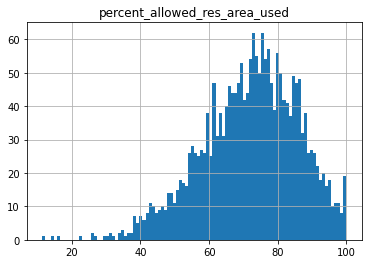

In [44]:
residential_plot_tract_gt_100_cleaned.hist(bins=100)

##### Calculate throwing the tax lots that were over 100 out

In [45]:
#Subset out the ones where more than 100% of allotted residential area was built
residential_plot_lt_100 = residential_analyze[residential_analyze['percent_allowed_res_area_used']<=100]

In [67]:
residential_plot_tract_lt_100 = residential_plot_lt_100[['Borough', 'CT2010', 'geometry', 'percent_allowed_res_area_used']].dissolve(by=["Borough","CT2010"], aggfunc = 'mean')

In [68]:
to_carto(residential_plot_tract_gt_100_cleaned, 'residential_tract_avg_built_percentage_gt_100_thrown_out', if_exists='replace')


Success! Data uploaded to table "residential_tract_avg_built_percentage_gt_100_thrown_out" correctly


'residential_tract_avg_built_percentage_gt_100_thrown_out'

<AxesSubplot:>

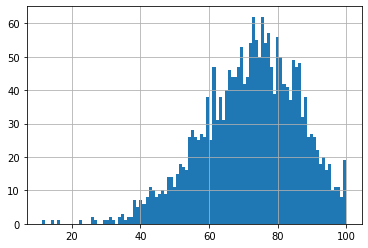

In [69]:
residential_plot_tract_gt_100_cleaned['percent_allowed_res_area_used'].hist(bins=100)

### Also calculate the built residential FAR at the tax lot and census tract level
The percent of allotted FAR used gives a sense of building behaviors, but it does not necessarily give a sense of urban density because some neighborhoods have higher permitted FARs (ie. higher possible building density) than other neighborhoods. Because of this there could be neighborhoods where most tax lots have used low percentages of the allotted FAR that are more densely built up than neighborhoods with high percentages of the allotted FAR used (if the low percentage neighborhood has higher allotted FARs than the high percentage neighborhood). Plotting the built FAR directly will give a sense of experienced urban density in each neighborhood.

#### Calculate at tax lot level

In [59]:
residential_analyze['built_resid_FAR'] = residential_analyze['ResArea']/residential_analyze['LotArea']

In [60]:
residential_analyze['built_resid_FAR'].describe()

count    748968.000000
mean          0.968227
std           1.341864
min           0.000001
25%           0.474714
50%           0.686079
75%           1.053312
max         359.384462
Name: built_resid_FAR, dtype: float64

<AxesSubplot:>

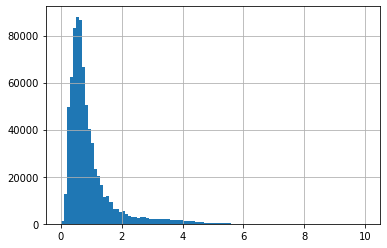

In [65]:
#Drop the extreme outliers which seem like there are likely errors in
residential_built_FAR_plot = residential_analyze[residential_analyze['built_resid_FAR']<10]
residential_built_FAR_plot['built_resid_FAR'].hist(bins=100)

In [76]:
residential_built_FAR_plot[residential_built_FAR_plot['geometry'].isna()]

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,Notes,Shape_Leng,Shape_Area,geometry,land_use_id,land_use_description,percent_allowed_res_area_used,"built_F""AR",built_FAR,built_resid_FAR


In [78]:
# Too granular to discern patterns, so using tract level analysis below
# to_carto(residential_built_FAR_plot[['Borough', 'built_resid_FAR','geometry']], 'residential_lot_built_FAR_outliers_thrown_out', geom_col ='geometry', if_exists='replace')


Success! Data uploaded to table "residential_lot_built_far_outliers_thrown_out" correctly


'residential_lot_built_far_outliers_thrown_out'

#### Calculate at census tract level weighing each tax lot builtFAR by LotArea
This makes larger lots contribute to the average more, giving an accurate sense of what each neighborhood would feel like walking through it

In [85]:
#Calculate weighted average at the tract level

def wavg(group, avg_name, weight_name):
    """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
    In rare instance, we may not have weights, so just return the mean. Customize this if your business case
    should return otherwise.
    """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()
    
residential_built_FAR_df=pd.DataFrame(residential_built_FAR_plot.groupby(["Borough","CT2010"]).apply(wavg, "built_resid_FAR", "LotArea")).reset_index()
residential_built_FAR_df.columns = ['Borough', 'CT2010', 'avg_built_FAR']

In [83]:
#Calculate aggregated geometries
tract_geometries = residential_built_FAR_plot[['Borough', 'CT2010', 'geometry']].dissolve(by=["Borough","CT2010"]).reset_index()

In [89]:
#Merge in geometries
residential_built_FAR_tract_gdf = tract_geometries.merge(residential_built_FAR_df, on = ['Borough', 'CT2010'], how='right')

#Check if merge worked - should be empty df
residential_built_FAR_tract_gdf[residential_built_FAR_tract_gdf['geometry'].isna()]

,Borough,CT2010,geometry,avg_built_FAR


In [90]:
residential_built_FAR_tract_gdf['avg_built_FAR'].describe()

count    2096.000000
mean        1.697028
std         1.357641
min         0.027515
25%         0.698112
50%         1.271330
75%         2.241535
max         9.133923
Name: avg_built_FAR, dtype: float64

In [91]:
to_carto(residential_built_FAR_tract_gdf, 'residential_tract_built_FAR_outliers_thrown_out', geom_col ='geometry', if_exists='replace')


Success! Data uploaded to table "residential_tract_built_far_outliers_thrown_out" correctly


'residential_tract_built_far_outliers_thrown_out'

### Import ACS race data at the tract level
Chose to import at the tract rather than the block group level because this makes it easier to discern NYC trends

In [7]:
# #Find the variable code for the race question I want to extract - long output
# sample = censusdata.search('acs5', 2018,'concept', 'race')
# print(len(sample))
# print(sample)

### B02001 has the race data

B02001_001E - total surveyed population
B02001_002E - number of people surveyed who identify as white
https://data.census.gov/cedsci/table?q=race&tid=ACSDT1Y2019.B02001&hidePreview=false

In [93]:
censusdata.censustable('acs5', 2018, 'B02001')

OrderedDict([('B02001_001E',
              {'label': 'Estimate!!Total',
               'concept': 'RACE',
               'predicateType': 'int'}),
             ('B02001_002E',
              {'label': 'Estimate!!Total!!White alone',
               'concept': 'RACE',
               'predicateType': 'int'}),
             ('B02001_003E',
              {'label': 'Estimate!!Total!!Black or African American alone',
               'concept': 'RACE',
               'predicateType': 'int'}),
             ('B02001_004E',
              {'label': 'Estimate!!Total!!American Indian and Alaska Native alone',
               'concept': 'RACE',
               'predicateType': 'int'}),
             ('B02001_005E',
              {'label': 'Estimate!!Total!!Asian alone',
               'concept': 'RACE',
               'predicateType': 'int'}),
             ('B02001_006E',
              {'label': 'Estimate!!Total!!Native Hawaiian and Other Pacific Islander alone',
               'concept': 'RACE',
         

In [94]:
'''
Keep codes same as in MapPluto
BX Bronx
BK Brooklyn
MN Manhattan
QN Queens
SI Staten Island
'''

#Census county codes for all New York counties
counties = {'BX':'005', 'MN':'061', 'BK':'047', 'QN':'081', 'SI':'085'}
counties_full = {'BX':'Bronx', 'MN':'Manhattan', 'BK':'Brooklyn', 'QN':'Queens', 'SI':'Staten Island'}

ACS_data_by_county = {}
for county_name, county_code in counties.items():
    data = censusdata.download('acs5', 2018,
               censusdata.censusgeo([('state', '36'),
                                     ('county', county_code),
                                    ('tract', '*')]),
              ['B02001_001E','B02001_002E'])
    print('There are {} census tracts in {} county'.format(data.shape[0], county_name))
    
    #Download returns a dataframe where index stores the geography info
    data.reset_index(inplace = True)
    data.rename(columns= {'index':'geocensus_object'}, inplace = True)
    
    #Index is a censusgeo object whose components can be accessed through .geo and .name
    example_row = data.iloc[0]
    geographies = [geo_code_tuple[0] for geo_code_tuple in example_row['geocensus_object'].geo]

    for i in range(len(geographies)):
        geography = geographies[i]
        data[geography] = data.apply(lambda row: row['geocensus_object'].geo[i][1], axis = 1)
        data['geography_name_str'] = data.apply(lambda row: row['geocensus_object'].name, axis = 1)
    
    #Drop the geocensus object
    data.drop(columns = 'geocensus_object', inplace = True)
    
    #Add in borough code
    data['county_code'] = county_name
    data['county_full_name'] = counties_full[county_name]
    
    #Add cleaned data to dictionary to concatenate later
    ACS_data_by_county[county_name] = data
    
ACS_df = pd.concat(list(ACS_data_by_county.values()), ignore_index = True, axis = 0, sort = False)
display(ACS_df.head())

There are 339 census tracts in BX county
There are 288 census tracts in MN county
There are 761 census tracts in BK county
There are 669 census tracts in QN county
There are 110 census tracts in SI county


,B02001_001E,B02001_002E,state,geography_name_str,county,tract,county_code,county_full_name
0,4205,485,36,"Census Tract 429.02, Bronx County, New York",005,042902,BX,Bronx
1,5885,2941,36,"Census Tract 330, Bronx County, New York",005,033000,BX,Bronx
2,8054,779,36,"Census Tract 358, Bronx County, New York",005,035800,BX,Bronx
3,4322,1122,36,"Census Tract 371, Bronx County, New York",005,037100,BX,Bronx
4,4757,344,36,"Census Tract 385, Bronx County, New York",005,038500,BX,Bronx


In [95]:
#Calculate the percent of people surveyed who identify as white v. non-white
ACS_df.rename(columns = {'B02001_002E':'num_households_white', 'B02001_001E':'total_households_surveyed'}, inplace=True)
ACS_df['percent_white'] = ACS_df['num_households_white']/ACS_df['total_households_surveyed']*100
ACS_df['percent_nonwhite'] = 100-ACS_df['percent_white']

ACS_df.head()

,total_households_surveyed,num_households_white,state,geography_name_str,county,tract,county_code,county_full_name,percent_white,percent_nonwhite
0,4205,485,36,"Census Tract 429.02, Bronx County, New York",005,042902,BX,Bronx,11.533888,88.466112
1,5885,2941,36,"Census Tract 330, Bronx County, New York",005,033000,BX,Bronx,49.974511,50.025489
2,8054,779,36,"Census Tract 358, Bronx County, New York",005,035800,BX,Bronx,9.672213,90.327787
3,4322,1122,36,"Census Tract 371, Bronx County, New York",005,037100,BX,Bronx,25.960204,74.039796
4,4757,344,36,"Census Tract 385, Bronx County, New York",005,038500,BX,Bronx,7.231448,92.768552


In [96]:
#Drop the census tracts that don't have any households surveyed
ACS_df = ACS_df[ACS_df['total_households_surveyed']!=0]

In [100]:
# Label each census tract by whether majority of population surveyed is white or nonwhite
ACS_df['majority_race'] = np.nan
ACS_df.loc[ACS_df['percent_nonwhite'] >=50, 'majority_race'] = 'Non-white'
ACS_df.loc[ACS_df['percent_nonwhite'] < 50, 'majority_race'] = 'White'


In [103]:
#Make sure calculation worked - should return empty df
ACS_df[ACS_df['majority_race'].isna()]

,total_households_surveyed,num_households_white,state,geography_name_str,county,tract,county_code,county_full_name,percent_white,percent_nonwhite,majority_race


#### Load census tract shapefiles to merge with race data
Source: https://www1.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page

I chose the ones where the shoreline is clipped to improve readability of map.


In [106]:
census_tract_gdf = gpd.read_file('raw_data/new_york_census_tracts_shoreline_clipped/nycb2010.shp')

census_tract_gdf = to_epsg_4326(census_tract_gdf)

Current CRS was epsg:2263. Reprojecting to epsg:4326.


In [107]:
#Merge census tracts shapefiles with ACS data using borough name and census tract ID (census tract ID is unique within borough)
ACS_gdf = census_tract_gdf[['CT2010','BoroName','geometry']].merge(ACS_df, left_on = ['CT2010', 'BoroName'], right_on = ['tract', 'county_full_name'], how = 'left')

#Check that the merge works for most (won't work for all)
no_geometry = ACS_gdf[ACS_gdf['percent_nonwhite'].isna()]
print("There are {} census tracts that are missing population data (probably be the ones where no housesholds were surveyed). Dropping these.".format(no_geometry.shape[0]))

ACS_gdf = ACS_gdf[~ACS_gdf['percent_nonwhite'].isna()]

There are 888 census tracts that are missing population data (probably be the ones where no housesholds were surveyed). Dropping these.


In [108]:
to_carto(ACS_gdf[['num_households_white', 'total_households_surveyed', 'percent_white', 'percent_nonwhite','majority_race','geometry', 'BoroName', 'CT2010']], 'ACS_race_gdf_tract', if_exists='replace')


Success! Data uploaded to table "acs_race_gdf_tract" correctly


'acs_race_gdf_tract'